# Basic simulation of electrodes in ESPResSo part I:
# Ion-pair in a narrow metallic slit-like confinement using ICC $\star$

## Prerequisites

To work with this tutorial, you should be familiar with the following topics:

-  Setting up and running simulations in ESPResSo - creating particles,
   incorporating interactions.
   If you are unfamiliar with this, you can go through the respective tutorial
   in the `lennard_jones` folder.
-  Basic knowledge of classical electrostatics:
   Dipoles, surface and image charges
-  Reduced units, as described in the **ESPResSo** [user guide](https://espressomd.github.io/doc/introduction.html#on-units)

## Introduction

This tutorial introduces some basic concepts for simulating charges close to an
electrode using **ESPResSo**.
In this first part, we focus on the interaction of a single ion pair confined in
a narrow metallic slit pore using the ICC $\star$-algorithm
<a href='#[1]'>[1]</a> for the computation of the surface polarization.
Here, we verify the strong deviation from a Coulomb-like interaction:
In metallic confinement, the ion pair interaction energy is screened
exponentially due to the presence of induced charges on the slit walls.
<a href='#[1]'>[2]</a>  

<font color='red'>Ionic-liquid-based nanoporous supercapacitors are promising for energy storage 

## Theoretical Background 

The normal component of electric field across a surface dividing two dielectric
media yields a discontinuity, which can be expressed in terms of a finite
surface charge density 
$(\epsilon_1\vec{E}_1 - \epsilon_2\vec{E}_2).\hat{n}=-\sigma(\vec{r})$.
This expression describes the jump in the electric field across the material
interface going from a dielectric medium $\epsilon_1$ to another one,
$\epsilon_2$.

While in the case of non-polarizable materials ($\epsilon_1 = \epsilon_2 = 1$),
this jump is only related to surface charges and dielectric contrast and the
potential is continuous across the interface, for polarizable materials also the
polarization field $\vec{P}$ will give a contribution. 
In order to solve the problem in presence of a jump of the dielectric constant
across an interface, one must know the electric fields on both sides. 

Another approach is to replace this two domain problem by an equivalent one
without the explicit presence of the dielectric jump.
This is achieved by introducing an additional fictitious charge i.e. an induced
charge density $\sigma_{ind}$ on the surface. 
With this well known "method of image charges", it is sufficient to know the
electric field on one side of the interface. **ESPResSo** provides "Induced Charge Calculation with fast Coulomb Solvers" (ICC  $\star$) algorithm <a href='#[1]'>[1]</a> which employs a  numerical scheme for solving the boundary integrals and the induced charge.   

*Note*: Apart from ICC $\star$, **ESPResSo** also has "Electrostatic layer correction with image charges" (ELC-IC) method <a href='#[1]'>[3]</a>, for planar 2D+h partially periodic systems with dielectric interfaces. Tutorial on *Basic simulation of electrodes in ESPResSo part II* addresses this in detail.   

## 2D+h periodic systems, dielectric interfaces and Induced Charge Computation with ICC $\star$

Partially periodic ionic systems with dielectric interfaces are very often
encountered in the study of energy materials or bio-macromolecular and membrane
studies. 
These systems usually exhibit a confinement along one ($z$) direction, where the confining boundary or interface imposes a dielectric discontinuity, while the other $x$-$y$ directions are periodic and exhibit bulk-like properties. 
- With ICC $\star$ the goal is to solve the Poisson equation for an inhomogeneous dieletric:
$$ \nabla (\epsilon \nabla \phi)=-4\pi \rho$$

- Integrating this at the boundary over an infinitesimally wide pillbox will give the induced surface charge as:
$$q_{ind} = \frac{1}{4\pi} \oint\, dA\, .\epsilon\nabla \phi = \frac{A}{4\pi}(\epsilon_1\vec{E}_1.\hat{n}-\epsilon_2\vec{E}_2.\hat{n})$$
- Electric field at the closest proximity of the interface $\vec{E}_{1/2}$ can be written as a sum of electric field contributions from the surface charge $\sigma$ and the external electric field $\vec{E}$:
$$ \vec{E}_{1/2} =\vec{E} + 2\pi/\epsilon_1\sigma\hat{n}  $$
- Eventually, the induced charge can be written in terms of the dielectric differences and the electric field as:
$$\sigma = \frac{\epsilon_1}{2\pi} \frac{\epsilon_1-\epsilon_2}{\epsilon_1+\epsilon_2}\vec{E}.\hat{n} $$


This boundary integral formulation is implemented via a numerical element scheme
by discretizing the interface initially with a set of spatially fixed ICC particles.  The initial charges are then iterated
over time until they correctly represent the influence of the dielectric
discontinuity.


##  1. System setup 


First we import all ESPResSo features and external modules

In [1]:
import espressomd
import numpy as np
import espressomd.electrostatics
import espressomd.electrostatic_extensions
from espressomd.interactions import *

espressomd.assert_features(['ELECTROSTATICS'])

import matplotlib.pyplot as plt
from scipy.special import *
from tqdm import tqdm

We define system dimensions and some physical parameters related to length, time
and energy scales of our system.
All physical parameters are defined in reduced units of length ($\sigma=1$;
Particle size), mass ($m=1$; Particle mass), time ($t=0.01 \tau$) and
elementary charge ($e=1$).

Another important length scale is the Bjerrum Length, which is the length at
which the electrostatic energy between two elementary charges is comparable to
the thermal energy $k_\mathrm{B}T$.
It is defined as $l_\mathrm{B}=\frac{1}{4\pi\epsilon_0\epsilon_rk_BT}$. 
In our case if we choose the ion size ($\sigma$) in simulations equivalent to a
typical experimental value for mono-atomar salt, 0.3 nm in real units, then the
Bjerrum length of water at room temperature, $\ell_\mathrm{B}=0.71 \,\mathrm{nm}$ is
$\ell_\mathrm{B}\sim 2$ in simulations units.

#### <font color='red'> Comment  on the choice of ELC GAP ???

In [2]:
#***************************************************
#            System Setup
#***************************************************

# Box dimensions
# To construct a narrow slit Lz << (Lx , Ly)
box_l_x = 100.
box_l_y = 100.
box_l_z = 5.

# ICC* with ELC: 2D electrostatics
ELC_GAP = 3*box_l_z

system = espressomd.System(box_l=[box_l_x, box_l_y, box_l_z+ELC_GAP])

# System Time
system.time_step = 0.01
system.cell_system.skin = 0.4

# Elementary charge 
q = np.array([1.0])  

# Interaction Parameters for P3M with ELC

BJERRUM_LENGTH = 2.0        # Electrostatic prefactor passed to P3M ; prefactor=lB KBT/e2                
ACCURACY = 1e-7             # P3M force accuracy      
CHECK_ACCURACY = 1e-5       # maximim pairwise error in ELC

#Lennard-Jones  Parameters

LJ_SIGMA = 1.0
LJ_EPSILON = 1.0                

#Particle parameters

types = {"Cation": 0, "Anion": 1  ,"Electrodes": 2}
charges = {"Cation": q[0], "Anion": -q[0]  }

p1=system.part.add(pos=[box_l_x/4.0, box_l_y/2.0, box_l_z/2.0], q=charges["Cation"])
print(f"Cation placed at position: {p1.pos}")
p2=system.part.add(pos=[3.0*box_l_x/4.0, box_l_y/2.0, box_l_z/2.0], q=charges["Anion"])
print(f"Anion placed at position: {p2.pos}")


Cation placed at position: [25.  50.   2.5]
Anion placed at position: [75.  50.   2.5]


### Exercise:
Set up electrostatics interactions between the ion pairs using P3M and ICC $\star$.  
#### Hints:
- Firstly instantiate a P3M object (using [*espressomd.electrostatics.P3M(...)*](https://espressomd.github.io/doc/espressomd.html#espressomd.electrostatics.P3M)) as the 3D Coulomb solver for the system.
- Since, we are working on a 2D+h partially periodic system, we use ELC in combination with P3M. For that instantiate ELC (using [*espressomd.electrostatics.ELC(...)*](https://espressomd.github.io/doc/espressomd.html#espressomd.electrostatics.ELC)) with p3m as the actor which calls necessary initialization routines.  
- Now to account for the 2D+h system with dielectric interface, add ICC in extension to  already added ELC-P3M actor. For that first create an ICC object using [*espressomd.electrostatic_extensions.ICC(...)*](https://espressomd.github.io/doc/espressomd.html#espressomd.electrostatic_extensions.ICC). 
- Setting up the ICC object requires specifying a fixed number of ICC particles and their initial charges. Since, the ICC particles are setup as normal ESPResSo particles, they should be manually added at the interfaces using [*system.part.add(..)*](https://espressomd.github.io/doc/espressomd.html?#module-espressomd.particle_data). 
*Note* - Refer to section [(**Dielectric interfaces with the ICC
 algorithm**)](https://espressomd.github.io/doc/electrostatics.html#dielectric-interfaces-with-the-icc-star-algorithm) in the **ESPResSo** documentation for basic ICC setup.


In [3]:
p3m = espressomd.electrostatics.P3M(
            prefactor=BJERRUM_LENGTH,
            accuracy=ACCURACY,
            check_neutrality = False,
            mesh = [100,100,150],
            cao = 5
        )

elc = espressomd.electrostatics.ELC(actor=p3m, gap_size=ELC_GAP, maxPWerror=CHECK_ACCURACY)

# Set the ICC line density and calculate the number of
# ICC particles according to the box size
nicc = 100  # linear density
nicc_per_electrode = nicc**2  # surface density
nicc_tot = 2 * nicc_per_electrode
iccArea = box_l_x * box_l_y / nicc_per_electrode
lx = box_l_x / nicc
ly = box_l_y / nicc

# Lists to collect required parameters
iccNormals = []
iccAreas = []
iccSigmas = []
iccEpsilons = []

# Add the fixed ICC particles:

# Bottom electrode (normal [0, 0, 1])
for xi in range(nicc):
    for yi in range(nicc):
        system.part.add(pos=[lx * xi, ly * yi, 0.], q=-0.0001,
                        type=types["Electrodes"], fix=[True, True, True])
iccNormals.extend([0, 0, 1] * nicc_per_electrode)

# Top electrode (normal [0, 0, -1])
for xi in range(nicc):
    for yi in range(nicc):
        system.part.add(pos=[lx * xi, ly * yi, box_l_z], q=0.0001,
                        type=types["Electrodes"], fix=[True, True, True])
iccNormals.extend([0, 0, -1] * nicc_per_electrode)

# Common area, sigma and metallic epsilon
iccAreas.extend([iccArea] * nicc_tot)
iccSigmas.extend([0] * nicc_tot)
iccEpsilons.extend([100000] * nicc_tot)

iccNormals = np.array(iccNormals, dtype=float).reshape(nicc_tot, 3)

icc = espressomd.electrostatic_extensions.ICC(
    first_id=2,
    n_icc=nicc_tot,
    convergence=1e-3,
    relaxation=0.95,
    ext_field=[0, 0, 0],
    max_iterations=1000,
    eps_out=1.0,
    normals=iccNormals,
    areas=np.array(iccAreas, dtype=float),
    sigmas=np.array(iccSigmas, dtype=float),
    epsilons=np.array(iccEpsilons, dtype=float)
    )

system.electrostatics.solver = elc
system.electrostatics.extension = icc

## 2. Calculation of the forces

<font color='red'> Why R depends on box_l_z instead of x , also why range(2-nicc)  ??

In [4]:
R = np.logspace(0,box_l_z/4.,10) 
elc_forces_axial = np.empty((len(R), 2))

for i, x in enumerate(tqdm(R)):
    p1.pos = [0, box_l_y/2.0, box_l_z/2.0]
    p2.pos = [x, box_l_y/2.0, box_l_z/2.0]

    system.integrator.run(0)
    elc_forces_axial[i, 0] = p1.f[0]
    elc_forces_axial[i, 1] = p2.f[0]
    
    # reset ICC charges to ensure charge neutrality check passes
    system.part.by_ids(range(2,2+nicc_per_electrode)).q = np.array([-0.0001]*nicc_per_electrode)
    system.part.by_ids(range(2+nicc_per_electrode,2+2*nicc_per_electrode)).q = np.array([0.0001]*nicc_per_electrode)    

  0%|                                                                                                                                                  | 0/10 [00:00<?, ?it/s]WARNING: Statistics of tuning samples is very bad.


CoulombP3M tune parameters: Accuracy goal = 1.00000e-07 prefactor = 2.00000e+00
System: box_l = 1.00000e+02 # charged part = 20002 Sum[q_i^2] = 2.00020e+00
mesh cao r_cut_iL    alpha_L     err       rs_err    ks_err    time [ms]
fixed mesh (100, 100, 150)
fixed cao 5
100  5   5.32500e-02 4.84390e+01 9.769e-08 7.071e-08 6.740e-08 885.61  

resulting parameters: mesh: (100, 100, 150), cao: 5, r_cut_iL: 5.3250e-02,
                      alpha_L: 4.8439e+01, accuracy: 9.7687e-08, time: 885.61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.36s/it]


## 3. Analysis and Interpretation of the data
**Comparison with mean field solution in an infinitely elongated narrow slit:** The electrostatic energy between two point charges in a slit-shaped charged nanopore formed by two infinitely extended, perfectly metallic walls <a href='#[1]'>[2]</a> is given as  
<font color='red'>????

In [5]:

def analytic_force_centered(R,w):
    x = R/w
    prefactor = BJERRUM_LENGTH / w**2

    def summand(x, n):
        return (-1)**n * x/(x**2+n**2)**(3./2)
    
    def do_sum(x):
        max = int(1e3)
        sum = 0
        for n in range(-max+1,max+1):
            sum += summand(x,n)
        return sum

    F = do_sum(x) * prefactor
    return F

def coulomb_force(x):
    prefactor = BJERRUM_LENGTH
    E = prefactor / x**2
    return E

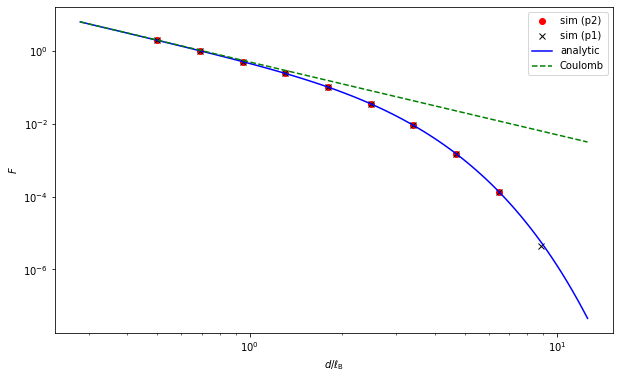

In [6]:
fig = plt.figure(figsize=(10, 6))

plt.plot(R/BJERRUM_LENGTH, -elc_forces_axial[:,1],  color='red' , label="sim (p2)",  marker='o', ls='')
plt.plot(R/BJERRUM_LENGTH, elc_forces_axial[:,0],  color='k' , label="sim (p1)",  marker='x', ls='')

x = np.logspace(-.25,1.4,100)

plt.plot(x/BJERRUM_LENGTH, analytic_force_centered(x,box_l_z),  color='b' , label="analytic",  marker='')
plt.plot(x/BJERRUM_LENGTH, coulomb_force(x), color='green', ls='--', label='Coulomb')

plt.xlabel(r'$d/\ell_\mathrm{B}$')
plt.ylabel(r'$F$')
plt.loglog()
plt.legend()

## References

<a id='[1]'></a>[1] Tyagi, S.; Süzen, M.; Sega, M.; Barbosa, M.; Kantorovich, S. S.; Holm, C. An Iterative, Fast, Linear-Scaling Method for Computing Induced Charges on Arbitrary Dielectric Boundaries. J. Chem. Phys. 2010, 132 (15), 154112. https://doi.org/10.1063/1.3376011.
 
<a id='[2]'></a>[2] Kondrat, S.; Feng, G.; Bresme, F.; Urbakh, M.; Kornyshev, A. A. Theory and Simulations of Ionic Liquids in Nanoconfinement. Chem. Rev. 2023, 123 (10), 6668–6715. https://doi.org/10.1021/acs.chemrev.2c00728.

<a id='[3]'></a>[3] Tyagi, S.; Arnold, A.; Holm, C. Electrostatic Layer Correction with Image Charges: A Linear Scaling Method to Treat Slab 2D+h Systems with Dielectric Interfaces. J. Chem. Phys. 2008, 129 (20), 204102. https://doi.org/10.1063/1.3021064.
